In [1]:
import torch 
from Ford_dataset import SatGrdDatasetFord, train_logs, train_logs_img_inds, test_logs, test_logs_img_inds, get_camera_mask
from torch.utils.data import DataLoader

logs_start = 0; logs_end = 5
range_lat = 20; range_lot=20; rotation_range =20; #meters, meters, degress
train_set  = SatGrdDatasetFord(logs=train_logs[logs_start:logs_end], logs_img_inds=train_logs_img_inds[logs_start:logs_end], mode='train')
val_set = SatGrdDatasetFord(logs=test_logs[logs_start:logs_end], logs_img_inds=test_logs_img_inds[logs_start:logs_end], mode='val')

train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=4, prefetch_factor=1)
val_loader = DataLoader(val_set, batch_size=4, shuffle=True, num_workers=4, prefetch_factor=1)

print(f'len train_set {len(train_loader)}, len val_set {len(val_loader)}')
device = 'cuda'


from models import UnetFeatures, UnetFlow
from torch import nn 
from torch.nn import functional as F


class Model(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.unet_feat = UnetFeatures(height=512, width=512)
        self.unet_flow = UnetFlow(height=64, width=64)
        self.ln = nn.LayerNorm([64*64, 64, 64])

    def forward(self, sat_img, sat_img_no_rot):
        B, _, _, _ = sat_img.shape

        img = torch.cat((sat_img, sat_img_no_rot), dim = 0)
        sat_img_feat, sat_img_no_rot_feat = torch.split(self.unet_feat(img), B, dim=0)

        _, C, H, W = sat_img_feat.shape
        sat_img_feat = sat_img_feat.view(B, C, H*W).transpose(1,2)
        sat_img_no_rot_feat = sat_img_no_rot_feat.view(B, C, H*W)

        out = (sat_img_feat @ sat_img_no_rot_feat) # * (1.0 / sat_img_no_rot_feat.size(-1) ** 0.5)
        #out = torch.nn.functional.softmax(out, dim=-1)
        out = out.transpose(1,2).view(B, H*W, H, W)
        out = self.ln(out)
        out = self.unet_flow(out)

        return out

len train_set 7937, len val_set 3585


In [2]:
Rs = train_set.Rs
Ts = train_set.Ts
Ks = train_set.Ks


cameras_mask = None
for camera in Rs.keys():
    R = Rs[camera]
    T = Ts[camera]
    K = Ks[camera]
    if cameras_mask is None:
        cameras_mask = get_camera_mask(R, T, K, 0, 0, 0, 448, 896, 512)
    else:
        cameras_mask = cameras_mask | get_camera_mask(R, T, K, 0, 0, 0, 448, 896, 512)

cameras_mask = cameras_mask.to(device)

In [3]:
# train and save model 

def eval_model(model, val_loader):
    model.eval()
    loss_sum = 0

    for sat_img, grd_imgs, gt_shift_u, gt_shift_v, theta, grd_names, sat_img_no_rot, mask_dt_xy, dt_xy in val_loader:
        sat_img_no_rot = sat_img_no_rot.to(device); sat_img = sat_img.to(device)
        mask_dt_xy = mask_dt_xy.to(device) ;dt_xy = dt_xy.to(device)

        with torch.no_grad():
            out = model(sat_img, sat_img_no_rot*cameras_mask)
            ce =  F.cross_entropy(out[:,:2, :, :], mask_dt_xy)  
            rmse = torch.mean( ( (dt_xy - F.tanh(out[:,2:, :, :])) **2 ) * mask_dt_xy.unsqueeze(1).float()) ** 0.5
            loss = ce + 5 * rmse
            loss_sum += loss.item()
            # print(loss, ce, rmse)

    model.train()
    return loss_sum/len(val_loader)

def get_lr(epoch):
    if epoch >=0 and epoch<1:
        lr = 3e-4
    elif epoch >=1 and epoch<2:
        lr = 1e-4
    elif epoch >=2:
        lr = 3e-5
    return lr

# torch.set_float32_matmul_precision('high')
model = Model().to(device)
model.load_state_dict(torch.load('model_conv.pth'))
# model = torch.compile(model)


loss_train = []
loss_val = []
epochs = 3


for epoch in range(epochs): 
    loop = 0
    train_loss_sum = 0
    train_loss_rmse_sum = 0
    train_loss_ce_sum = 0
    lr = get_lr(epoch)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    for sat_img, grd_imgs, gt_shift_u, gt_shift_v, theta, grd_names, sat_img_no_rot, mask_dt_xy, dt_xy in train_loader:
        sat_img_no_rot = sat_img_no_rot.to(device); sat_img = sat_img.to(device)
        mask_dt_xy = mask_dt_xy.to(device) ;dt_xy = dt_xy.to(device); 
        
        optimizer.zero_grad()
        # time_start = time.time()
        out = model(sat_img, sat_img_no_rot*cameras_mask)
        ce =  F.cross_entropy(out[:,:2, :, :], mask_dt_xy)  
        rmse = torch.mean( ( (dt_xy - F.tanh(out[:,2:, :, :])) **2 ) * mask_dt_xy.unsqueeze(1).float()) ** 0.5
        loss = ce + 5 * rmse

        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()
        train_loss_rmse_sum += rmse.item()
        train_loss_ce_sum += ce.item()
        if loop%100 == 0:
            print(f'epoch {epoch} loop {loop} avg_loss = {train_loss_sum/(loop+1)} avg_loss_ce = {train_loss_ce_sum/(loop+1)} avg_loss_rmse = {train_loss_rmse_sum/(loop+1)}')#, f'time perstep {time.time()-time_start}')
        loop+=1
    
    loss_train.append(train_loss_sum/len(train_loader))
    loss_val.append(eval_model(model, val_loader))

    print(f'train_loss = {loss_train[-1]} val_loss = {loss_val[-1]}')

# torch.save(model.state_dict(), 'model_conv.pth')

# normalization method = batch norm, batch_size = 4
# epoch 2 loop 7900 train_avg_loss = 0.03096659821379775 avg_loss_ce = 0.011037932387004451 avg_loss_rmse = 0.003985733163578762, val_loss = ?

# normalization method = layer norm, batch_size = 4
# epoch 2 loop 7900 avg_loss = 0.812329854441359 avg_loss_ce = 0.33058378204124333 avg_loss_rmse = 0.09634921447700555
# train_loss = 0.8123770771090294 val_loss = 0.8150691562782937, 

epoch 0 loop 0 avg_loss = 8.337576866149902 avg_loss_ce = 8.213375091552734 avg_loss_rmse = 0.024840444326400757
epoch 0 loop 100 avg_loss = 0.5808148853259512 avg_loss_ce = 0.46569688765719386 avg_loss_rmse = 0.0230236010957915
epoch 0 loop 200 avg_loss = 0.3758987450777595 avg_loss_ce = 0.28372784120155803 avg_loss_rmse = 0.01843418154300223
epoch 0 loop 300 avg_loss = 0.30034613708325003 avg_loss_ce = 0.21879670919968044 avg_loss_rmse = 0.016309886042994024
epoch 0 loop 400 avg_loss = 0.2550171881245259 avg_loss_ce = 0.18161921042419432 avg_loss_rmse = 0.014679595852442587
epoch 0 loop 500 avg_loss = 0.2314977227541025 avg_loss_ce = 0.16159117586925595 avg_loss_rmse = 0.013981309606918615
epoch 0 loop 600 avg_loss = 0.21251438093215178 avg_loss_ce = 0.1456914086223343 avg_loss_rmse = 0.01336459464512877
epoch 0 loop 700 avg_loss = 0.19771160156640108 avg_loss_ce = 0.13366382414695624 avg_loss_rmse = 0.012809555640127961
epoch 0 loop 800 avg_loss = 0.18714228200815738 avg_loss_ce = 0

KeyboardInterrupt: 

In [5]:
from Ford_dataset import get_xy_map
from matplotlib import pyplot as plt 

model =Model().to(device)
model.load_state_dict(torch.load('model_conv_FL.pth'))

def visualize_dt_xy(sat_img, sat_img_no_rot, dt_xy_mask, dt_xy, mask_dt_xy_pred, dt_xy_pred):
    # torch.manual_seed(123)
    """
    shift_x, shift_y, theta [-1,1] -> numpy.random
    """
    meters_per_pixel = 0.22
    sidelength_orig = 512

    sidelength = dt_xy_mask.shape[-1]
    xy_map = get_xy_map(sidelength)

    idxs = torch.randint(0,sidelength*sidelength-1,(30,))



    sc_x = xy_map.view(2,-1)[0,idxs]*sidelength_orig+sidelength_orig//2 
    sc_y = xy_map.view(2,-1)[1,idxs]*sidelength_orig+sidelength_orig//2 


    sc_x_dt = dt_xy.view(2,-1)[0,idxs]*sidelength_orig
    sc_y_dt = dt_xy.view(2,-1)[1,idxs]*sidelength_orig


    plt.figure(figsize=(20,20))
    # plt.subplot(2,2,1)
    # plt.title(f'displacment of the vehicle from ground truth \n v = {gt_shift_v:.2f} u = {gt_shift_u:.2f}  th = {theta:.2f}')
    # plt.imshow((sat_img).permute([1,2,0]), cmap='hot')
    # plt.subplot(2,2,2)
    # plt.title('no rot no trans')
    # plt.imshow(sat_img_no_rot.permute([1,2,0]))


    dt_xy_mask = torch.nn.functional.interpolate(dt_xy_mask[None, None, ...].float(), size=(512, 512), mode='nearest')[0,0]
    plt.subplot(2,2,1)
    plt.imshow((dt_xy_mask*sat_img).permute([1,2,0]), cmap='hot')
    plt.scatter(sc_y, sc_x, s=10, color = (0,0,1))
    plt.scatter(sc_y+0.2*sc_y_dt, sc_x+0.2*sc_x_dt, s=10, color=(0.2,0,0.8))
    plt.scatter(sc_y+0.4*sc_y_dt, sc_x+0.4*sc_x_dt, s=10, color=(0.4,0,0.6))
    plt.scatter(sc_y+0.6*sc_y_dt, sc_x+0.6*sc_x_dt, s=10, color=(0.6,0,0.4))
    plt.scatter(sc_y+0.8*sc_y_dt, sc_x+0.8*sc_x_dt, s=10, color=(0.8,0,0.2))
    plt.scatter(sc_y+1.0*sc_y_dt, sc_x+1.0*sc_x_dt, s=10, color=(1.0,0,0.0))
    
    plt.subplot(2,2,2)
    plt.imshow(sat_img_no_rot.permute([1,2,0]) , cmap='hot')
    plt.scatter(sc_y, sc_x, s=10, color = (0,0,1))
    plt.scatter(sc_y+0.2*sc_y_dt, sc_x+0.2*sc_x_dt, s=10, color=(0.2,0,0.8))
    plt.scatter(sc_y+0.4*sc_y_dt, sc_x+0.4*sc_x_dt, s=10, color=(0.4,0,0.6))
    plt.scatter(sc_y+0.6*sc_y_dt, sc_x+0.6*sc_x_dt, s=10, color=(0.6,0,0.4))
    plt.scatter(sc_y+0.8*sc_y_dt, sc_x+0.8*sc_x_dt, s=10, color=(0.8,0,0.2))
    plt.scatter(sc_y+1.0*sc_y_dt, sc_x+1.0*sc_x_dt, s=10, color=(1.0,0,0.0))


    sc_x_dt_pred = dt_xy_pred.view(2,-1)[0,idxs]*sidelength_orig
    sc_y_dt_pred = dt_xy_pred.view(2,-1)[1,idxs]*sidelength_orig
    
    mask_dt_xy_pred = torch.nn.functional.interpolate(mask_dt_xy_pred[None, None, ...].float(), size=(512, 512), mode='nearest')[0,0]

    plt.subplot(2,2,3)
    plt.imshow((mask_dt_xy_pred*sat_img).permute([1,2,0]), cmap='hot')
    plt.imshow((mask_dt_xy_pred*sat_img).permute([1,2,0]), cmap='hot')
    plt.scatter(sc_y, sc_x, s=10, color = (0,0,1))
    plt.scatter(sc_y+0.2*sc_y_dt_pred, sc_x+0.2*sc_x_dt_pred, s=10, color=(0.2,0,0.8))
    plt.scatter(sc_y+0.4*sc_y_dt_pred, sc_x+0.4*sc_x_dt_pred, s=10, color=(0.4,0,0.6))
    plt.scatter(sc_y+0.6*sc_y_dt_pred, sc_x+0.6*sc_x_dt_pred, s=10, color=(0.6,0,0.4))
    plt.scatter(sc_y+0.8*sc_y_dt_pred, sc_x+0.8*sc_x_dt_pred, s=10, color=(0.8,0,0.2))
    plt.scatter(sc_y+1.0*sc_y_dt_pred, sc_x+1.0*sc_x_dt_pred, s=10, color=(1.0,0,0.0))
    
    plt.subplot(2,2,4)
    plt.imshow(sat_img_no_rot.permute([1,2,0]) , cmap='hot')
    plt.scatter(sc_y, sc_x, s=10, color = (0,0,1))
    plt.scatter(sc_y+0.2*sc_y_dt_pred, sc_x+0.2*sc_x_dt_pred, s=10, color=(0.2,0,0.8))
    plt.scatter(sc_y+0.4*sc_y_dt_pred, sc_x+0.4*sc_x_dt_pred, s=10, color=(0.4,0,0.6))
    plt.scatter(sc_y+0.6*sc_y_dt_pred, sc_x+0.6*sc_x_dt_pred, s=10, color=(0.6,0,0.4))
    plt.scatter(sc_y+0.8*sc_y_dt_pred, sc_x+0.8*sc_x_dt_pred, s=10, color=(0.8,0,0.2))
    plt.scatter(sc_y+1.0*sc_y_dt_pred, sc_x+1.0*sc_x_dt_pred, s=10, color=(1.0,0,0.0))
    plt.show()

tensor(0.0119, device='cuda:0') tensor(0.0071, device='cuda:0') tensor(0.0010, device='cuda:0')


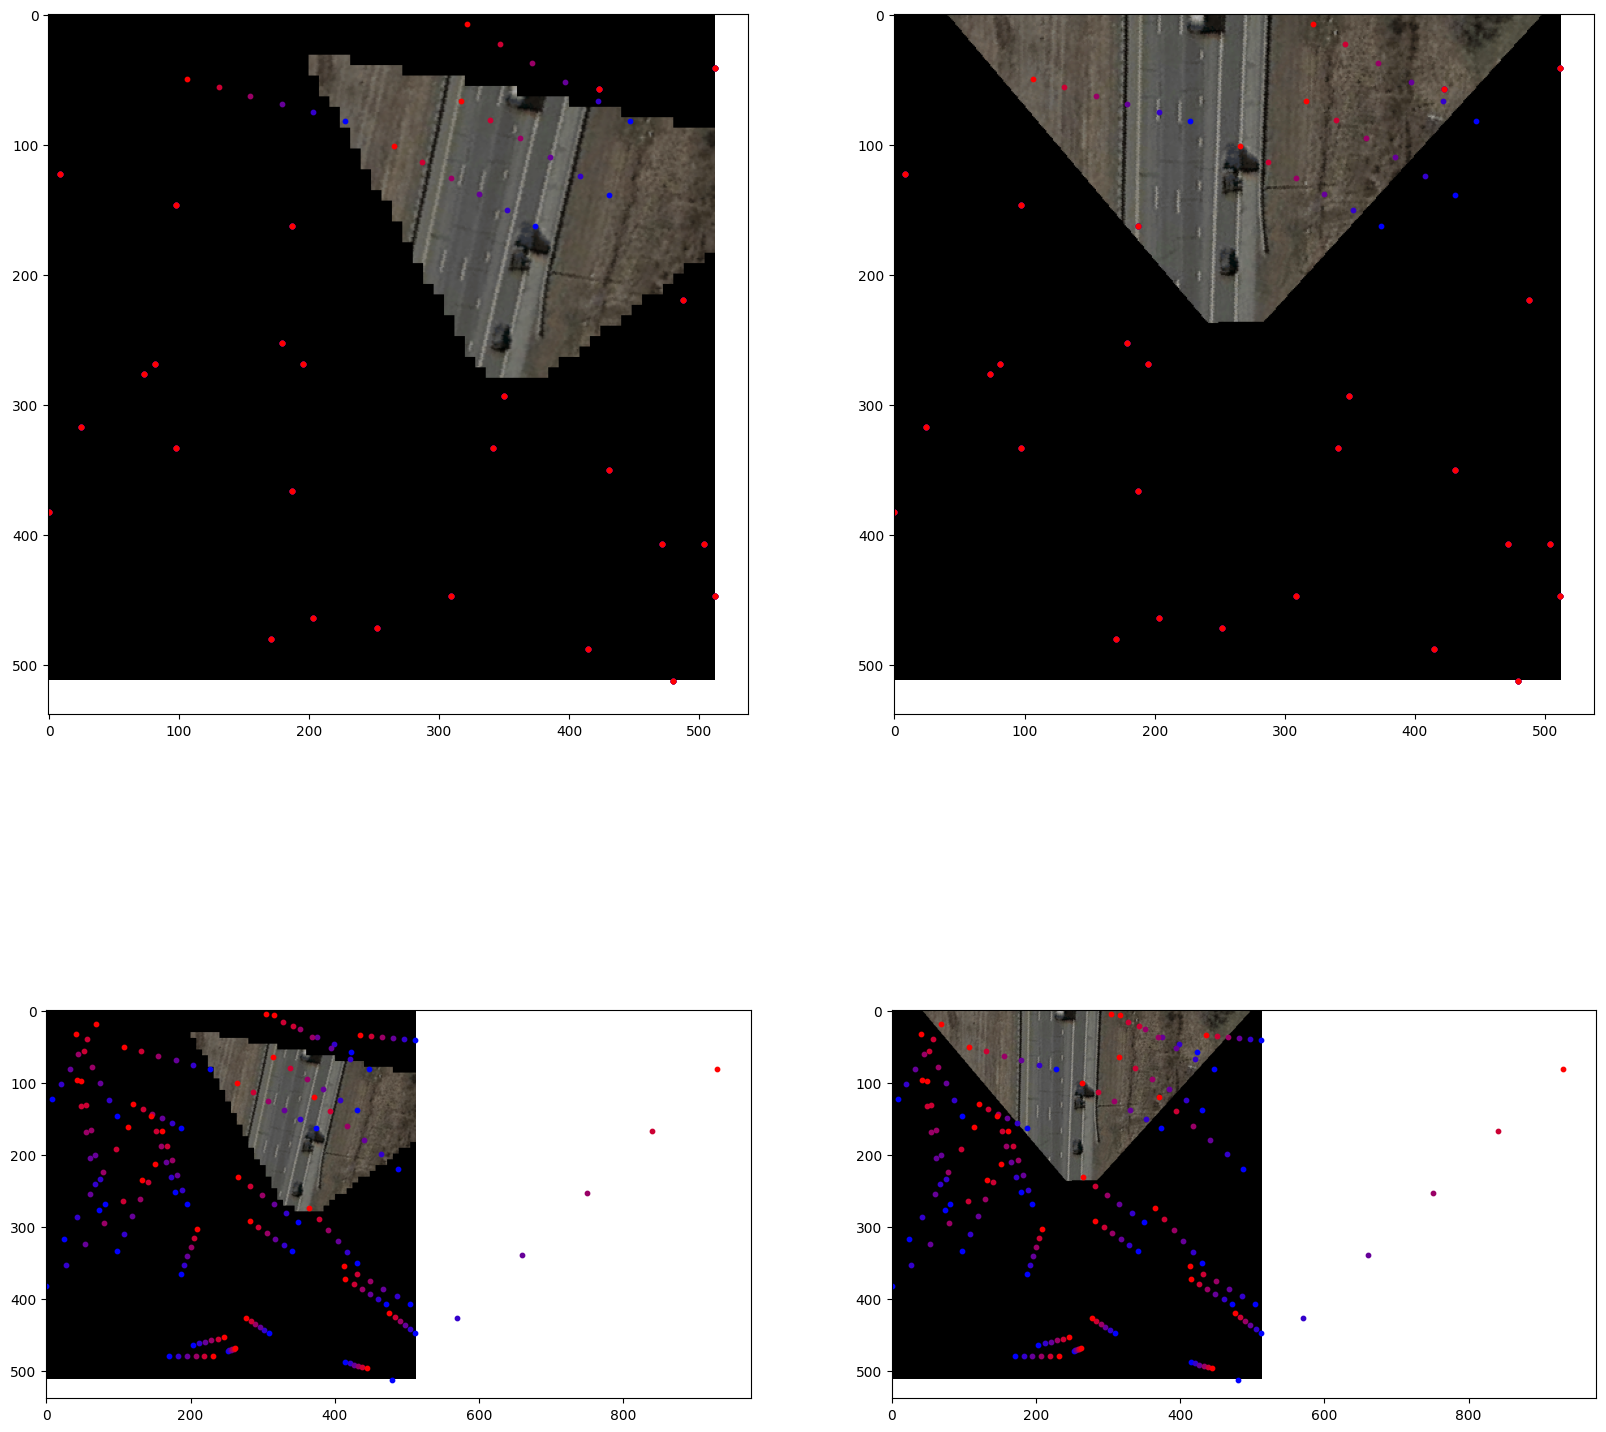

In [22]:
img_idx = 1100
sat_img, grd_imgs, gt_shift_u, gt_shift_v, theta, grd_names, sat_img_no_rot, mask_dt_xy, dt_xy = val_set[img_idx]
sat_img = sat_img.to(device)[None, ...]; sat_img_no_rot =sat_img_no_rot.to(device)[None, ...]; mask_dt_xy = mask_dt_xy[None, ...].to(device); dt_xy = dt_xy[None, ...].to(device)


with torch.no_grad():
    model.eval()
    out = model(sat_img, sat_img_no_rot*cameras_mask)
    ce =  F.cross_entropy(out[:,:2, :, :], mask_dt_xy)  
    rmse = torch.mean( ( (dt_xy - F.tanh(out[:,2:, :, :])) **2 ) * mask_dt_xy.unsqueeze(1).float()) ** 0.5
    loss = ce + 5 * rmse
    print(loss, ce, rmse)

mask_dt_xy_pred = torch.argmax(out[0, :2, :, :], dim=0).cpu()
dt_xy_pred = out[0, 2:, :, :].cpu()

visualize_dt_xy(sat_img[0].cpu(), sat_img_no_rot[0].cpu()*cameras_mask.cpu(), mask_dt_xy[0].cpu(), dt_xy[0].cpu(), mask_dt_xy_pred, dt_xy_pred)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..18.441637].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..15.496582].


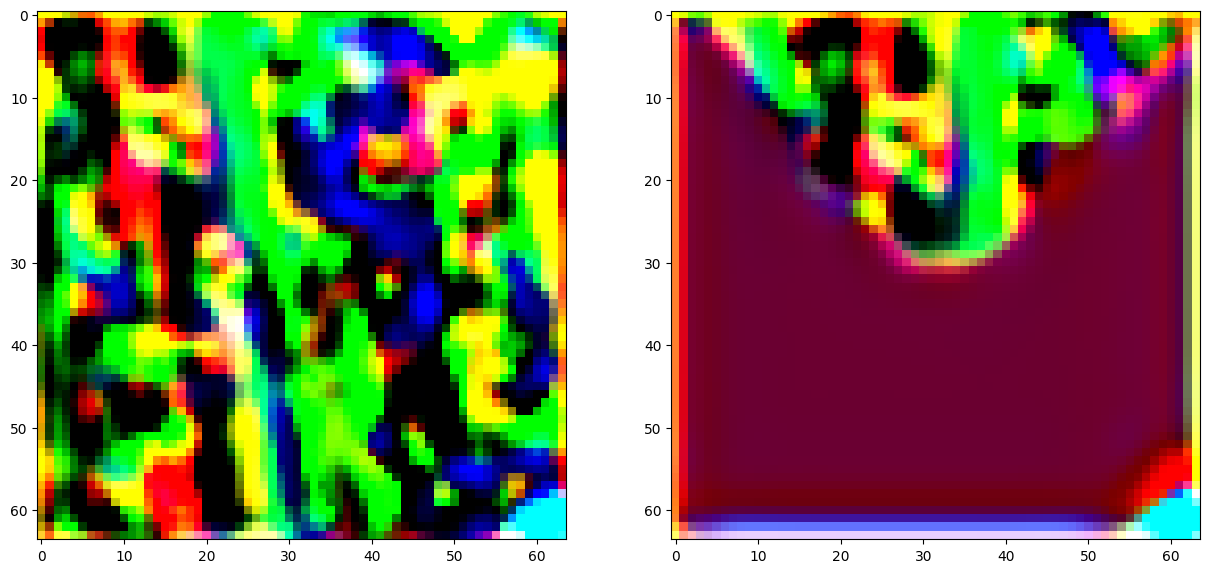

In [25]:
idx = 5
with torch.no_grad():
    img = torch.cat((sat_img, sat_img_no_rot*cameras_mask), dim = 0)
    sat_img_feat, sat_img_no_rot_feat = torch.split(model.unet_feat(img), 1, dim=0)
    sat_img_feat = sat_img_feat[0].cpu().permute([1,2,0])[:,:, idx *3: (idx+1)*3]
    sat_img_no_rot_feat = sat_img_no_rot_feat[0].cpu().permute([1,2,0])[:,:, idx *3: (idx+1)*3]

    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.imshow(sat_img_feat)
    plt.subplot(1,2,2)
    plt.imshow(sat_img_no_rot_feat)

In [26]:
# using optical flow predict dx, dy, dth
import numpy as np 
from Ford_dataset import get_xy_map
img_idx = 200
sat_img, grd_imgs, gt_shift_u, gt_shift_v, theta, grd_names, sat_img_no_rot, mask_dt_xy, dt_xy = val_set[img_idx]
sat_img = sat_img.to(device)[None, ...]; sat_img_no_rot =sat_img_no_rot.to(device)[None, ...]; mask_dt_xy = mask_dt_xy[None, ...].to(device); dt_xy = dt_xy[None, ...].to(device)

'''
x positive down 
y positive left 
th positive clock wise 
'''
meters_per_pixel = 0.22; sidelength_orig = 512
range_lat = 20; range_lot = 20; rotation_range = 20
dx = (gt_shift_v * range_lat) / (meters_per_pixel * sidelength_orig) #range [-0.5, 0.5] -0.5 bottom part of map +0.5 top part of the satelite map
dy = (gt_shift_u * range_lot) / (meters_per_pixel * sidelength_orig) #range [-0.5, 0.5] -0.5 left part of map +0.5 right part of the satelite map
dth = theta * rotation_range * torch.pi/ 180 # in rads, range[-20,20] degrees 

print(f' dx = {dx:.3f}, dy = {dy:.3f}, dth = {dth:.3f}')
print(f' dx_meters = {gt_shift_v * range_lat:.3f}, dy_meters = {gt_shift_u * range_lot:.3f}, dth_degrees = {theta * rotation_range:.3f}')


model =Model().to(device)
model.load_state_dict(torch.load('model_conv_FL.pth'))

with torch.no_grad():
    model.eval()
    out = model(sat_img, sat_img_no_rot*cameras_mask)
    # ce =  F.cross_entropy(out[:,:2, :, :], mask_dt_xy)  
    # rmse = torch.mean( ( (dt_xy - F.tanh(out[:,2:, :, :])) **2 ) * mask_dt_xy.unsqueeze(1).float()) ** 0.5
    # loss = ce + 5 * rmse
    # print(loss, ce, rmse)
mask_dt_xy_pred = torch.argmax(out[0, :2, :, :], dim=0)
dt_xy_pred = out[0, 2:, :, :]

'''
xy_nrt = xy with no rotation no translation,where the pixels would be in the original satelite image without the gps error compered to the satelite image with the gps error 
xy_nrt = A @ xy
dt_xy = (xy_nrt - xy)
xy_nrt = xy + dt_xy

A = xy_nrt @ sudo_inverse(xy)

A = xy_nrt_filtered @ sudo_inverse(xy_filtered)
we want to use the mask_dt_xy to use the filtered pixels 

A = [
            [ torch.cos(dth), torch.sin(dth), dx],
            [-torch.sin(dth), torch.cos(dth), dy],
            [0              , 0             , 1]
    ]
'''


idxs = mask_dt_xy_pred.view(-1).type(torch.bool)# from int64 to bool 
dt_xy_filtered = dt_xy_pred.view(2, -1)[:, idxs]

side_length = 64
xy = get_xy_map(side_length).to(device)
xy_filtered  = xy.view(2, -1)[:, idxs]
xy_nrt_filtered = xy_filtered + dt_xy_filtered

xy_filtered = torch.concat((xy_filtered, torch.ones_like(xy_filtered[0:1, :])))
xy_nrt_filtered = torch.concat((xy_nrt_filtered, torch.ones_like(xy_nrt_filtered[0:1, :])))


# A = torch.tensor([
#             [torch.cos(dth), torch.sin(dth), dx],
#             [-torch.sin(dth), torch.cos(dth), dy],
#             [0,0,1]
#         ]).to(device)


A_pred =  xy_nrt_filtered  @ torch.linalg.pinv(xy_filtered)
dth_pred = torch.arctan( A_pred[0,1]/ A_pred[0,0])
dx_pred = A_pred[0,2]
dy_pred = A_pred[1,2]

print(f'dx_pred = {dx_pred :.3f} dy_pred = {dy_pred :.3f} dth_pred = {dth_pred :.3f}')
print(f' dx_meters_pred = {dx_pred * (meters_per_pixel * sidelength_orig) :.3f}, dy_meters_pred = {dy_pred * (meters_per_pixel * sidelength_orig) :.3f}, dth_degrees_pred = {dth_pred  * 180 / torch.pi :.3f}')

# A, A_pred
# out = A @ xy_filtered
# torch.abs(xy_nrt_filtered[:2, :] - out[:2, :]).mean()
# dt_xy_filtered = torch.concat((dt_xy_filtered, torch.ones_like(dt_xy_filtered[0:1, :])))



c:\Users\dimitris\Desktop\MyFiles\diplomatikh\pytorch-tensorflow\pytorch\Cross-View-Localization\Simple Cross View Geolocalization\Ford_dataset.py:450: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_rad = torch.tensor(theta_rad)
c:\Users\dimitris\Desktop\MyFiles\diplomatikh\pytorch-tensorflow\pytorch\Cross-View-Localization\Simple Cross View Geolocalization\Ford_dataset.py:421: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_rad = theta * torch.pi/ 180 ;theta_rad = torch.tensor(theta_rad)


 dx = 0.051, dy = 0.159, dth = 0.149
 dx_meters = 5.760, dy_meters = 17.899, dth_degrees = 8.524
dx_pred = 0.052 dy_pred = 0.161 dth_pred = 0.152
 dx_meters_pred = 5.831, dy_meters_pred = 18.089, dth_degrees_pred = 8.724
